## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import pickle
import json 

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import VarianceThreshold

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR


colors_palette = ['#ffa600','#ff6361','#bc5090','#58508d', '#65345a']
np.random.seed(1234)

## 2. Load data 📊

In [2]:
df_train = pd.read_csv("../../data/train/caco/caco_pubchem_train.csv")
df_test = pd.read_csv("../../data/train/caco/caco_pubchem_test.csv")
df_valid = pd.read_csv("../../data/train/caco/caco_pubchem_valid.csv")

In [3]:
df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train = df_train_all.loc[:, df_train_all.columns != 'permeability']
y_train = df_train_all['permeability']

X_test = df_test.loc[:, df_test.columns != 'permeability']
y_test = df_test['permeability']

In [5]:
X_train.shape, y_train.shape

((2811, 881), (2811,))

In [6]:
X_test.shape, y_test.shape

((704, 881), (704,))

## 3. Remove low variance features

In [7]:
def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data.columns[selection.get_support(indices=True)]

idxs = remove_low_variance(X_train, threshold=0.01)
X_train = X_train[idxs.tolist()]
X_test = X_test[idxs.tolist()]
X_train

,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,...,PubchemFP821,PubchemFP822,PubchemFP824,PubchemFP826,PubchemFP830,PubchemFP833,PubchemFP834,PubchemFP839,PubchemFP840,PubchemFP860
0,1,1,0,0,0,1,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,1,1,0,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,1,1,0,1,...,0,1,0,0,0,1,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1,1,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
347,1,1,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
348,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
349,1,1,0,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
X_test

,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,...,PubchemFP821,PubchemFP822,PubchemFP824,PubchemFP826,PubchemFP830,PubchemFP833,PubchemFP834,PubchemFP839,PubchemFP840,PubchemFP860
0,1,1,0,1,0,1,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1,1,1,0,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4,1,1,0,1,0,1,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,1,1,0,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
700,1,1,0,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
701,1,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
702,1,1,1,1,1,1,1,1,0,1,...,1,0,0,0,0,0,0,0,0,0


In [157]:
# write
idxs_dict = {
    'caco': idxs.tolist()
}

with open('../../pubchem_idxs.txt', 'w') as json_file:
    json.dump(idxs_dict, json_file)

In [ ]:
# read
'''
with open('../../pubchem_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train = X_train[idxs['caco']]
X_train
'''

## 4. Metrics 📏

In [9]:
def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# 5. Models ⚙️

## 5.1. Ridge Regression

Poor results.

In [10]:
# default: 'alpha': 1.0, 'solver': 'auto', 'random_state': None, 
params = {
    'alpha': [1, 20, 50, 100],
    'solver': ['cholesky', 'svd','lsqr'],
    'tol': [0.001, 0.0001],
}

grid = GridSearchCV(Ridge(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

ridge = Ridge(alpha=100, solver='cholesky', tol=0.0001)
ridge.fit(X_train, y_train)

ridge_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, ridge_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, ridge.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, ridge_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, ridge.predict(X_train))

Best params:  {'alpha': 20, 'solver': 'svd', 'tol': 0.001} 

Test set:
Tuned model:
MAE: 13.999112648069756
MSE: 686.0971411190792
RMSE: 26.193456074353364
R2 Square 0.33743023852637355 

Base model:
MAE: 14.077930410360102
MSE: 769.6675880713311
RMSE: 27.74288355725358
R2 Square 0.25672555724307455 

Train set:
Tuned model:
MAE: 12.040559127592937
MSE: 451.36327678672086
RMSE: 21.24531187784074
R2 Square 0.479860212468983 

Base model:
MAE: 12.426556195024656
MSE: 528.9501045344072
RMSE: 22.998915290387224
R2 Square 0.3904510864382087 



In [11]:
results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, ridge_tuned.predict(X_test))]],                           columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,13.999113,686.097141,26.193456,0.33743


## 5.2. Random Forest Regressor

Better results - first model.

'max_depth': None --> overfitting

In [20]:
# default: 'n_estimators': 100, 'max_depth': None
params = {
    'max_depth': [4, 6, 8],
    'n_estimators': [500, 1000, 1500, 2000],
}

grid = GridSearchCV(RandomForestRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train) 

rf_reg = RandomForestRegressor(random_state=0, max_depth=13)
rf_reg.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, rf_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, rf_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, rf_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, rf_reg.predict(X_train))

Best params:  {'max_depth': 8, 'n_estimators': 2000} 

Test set:
Tuned model:
MAE: 11.583440232654198
MSE: 570.5884959901628
RMSE: 23.88699428538808
R2 Square 0.4489779055613612 

Base model:
MAE: 10.533161167415262
MSE: 536.2318832517784
RMSE: 23.156681179559786
R2 Square 0.4821563745314894 

Train set:
Tuned model:
MAE: 9.287751878960767
MSE: 241.02492360009745
RMSE: 15.524977410614724
R2 Square 0.7222488868754983 

Base model:
MAE: 6.66332516080887
MSE: 159.42894226190901
RMSE: 12.626517424132
R2 Square 0.8162780615544224 



In [21]:
params = {'max_depth': 8, 'n_estimators': 2000} 

rf_best = RandomForestRegressor(random_state=0, **params)
rf_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, rf_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, rf_best.predict(X_train))

Test set:
MAE: 11.583440232654198
MSE: 570.5884959901628
RMSE: 23.88699428538808
R2 Square 0.4489779055613612 

Train set:
MAE: 9.287751878960767
MSE: 241.02492360009745
RMSE: 15.524977410614724
R2 Square 0.7222488868754983 



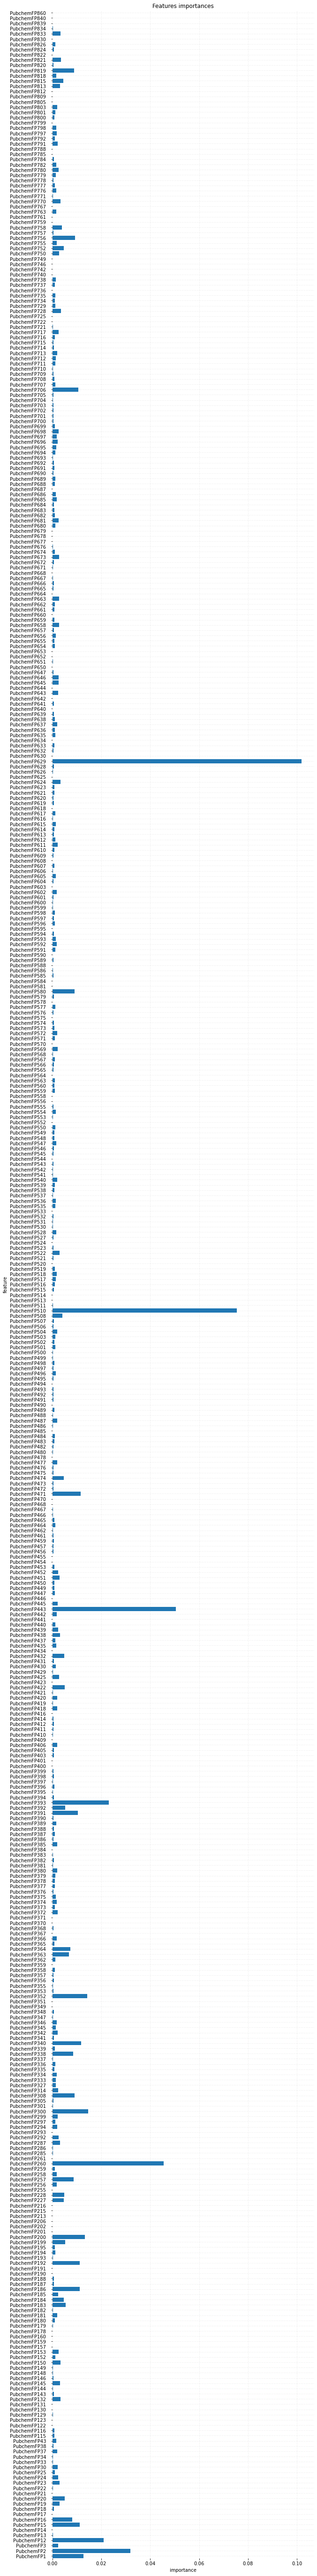

In [22]:
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), rf_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [23]:
results_df = results_df.append(pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, rf_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,13.999113,686.097141,26.193456,0.337430
1,Random Forest Regressor,11.583440,570.588496,23.886994,0.448978


## 5.3. XGBoost

Better results - second model.

'max_depth': None --> overfitting

In [178]:
# default: 'booster': gbtree, 'eta': 0.3, 'gamma': 0, 'max_depth': 6 
params = {
    'eta': [0.001, 0.005, 0.01],
    'lambda': [0.4, 0.6, 0.8],
    'gamma': [0.1, 0.5, 0.8],
    'max_depth': [5, 10, 15],
    'n_estimators': [500, 1000, 3000, 4000],
    'min_child_weight': [80, 95, 120, 150],
    'colsample_bytree': [0.4],
    'subsample': [0.8, 0.9]   
}

grid = GridSearchCV(xgb.XGBRegressor(verbosity=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

xgbr = xgb.XGBRegressor(verbosity=0, max_depth=5) 
xgbr.fit(X_train, y_train)

xgbr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, xgbr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, xgbr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, xgbr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, xgbr.predict(X_train))


Best params:  {'colsample_bytree': 0.4, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.4, 'max_depth': 15, 'min_child_weight': 120, 'n_estimators': 4000, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 10.880064875912005
MSE: 541.4287232338233
RMSE: 23.268620999832013
R2 Square 0.4771377425900942 

Base model:
MAE: 10.305025569225746
MSE: 496.4301150724856
RMSE: 22.280711727242593
R2 Square 0.5205932757635345 

Train set:
Tuned model:
MAE: 8.04730407488877
MSE: 259.965897143154
RMSE: 16.123457977219218
R2 Square 0.7004217811693083 

Base model:
MAE: 5.5641935501574515
MSE: 130.9333449579271
RMSE: 11.44261093273415
R2 Square 0.8491156774827252 



In [24]:
params = {'colsample_bytree': 0.4, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.4, 'max_depth': 15, 
          'min_child_weight': 120, 'n_estimators': 4000, 'subsample': 0.9} 

xgbr_best = xgb.XGBRegressor(**params) 
xgbr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, xgbr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, xgbr_best.predict(X_train))

Test set:
MAE: 10.880064875912005
MSE: 541.4287232338233
RMSE: 23.268620999832013
R2 Square 0.4771377425900942 

Train set:
MAE: 8.04730407488877
MSE: 259.965897143154
RMSE: 16.123457977219218
R2 Square 0.7004217811693083 



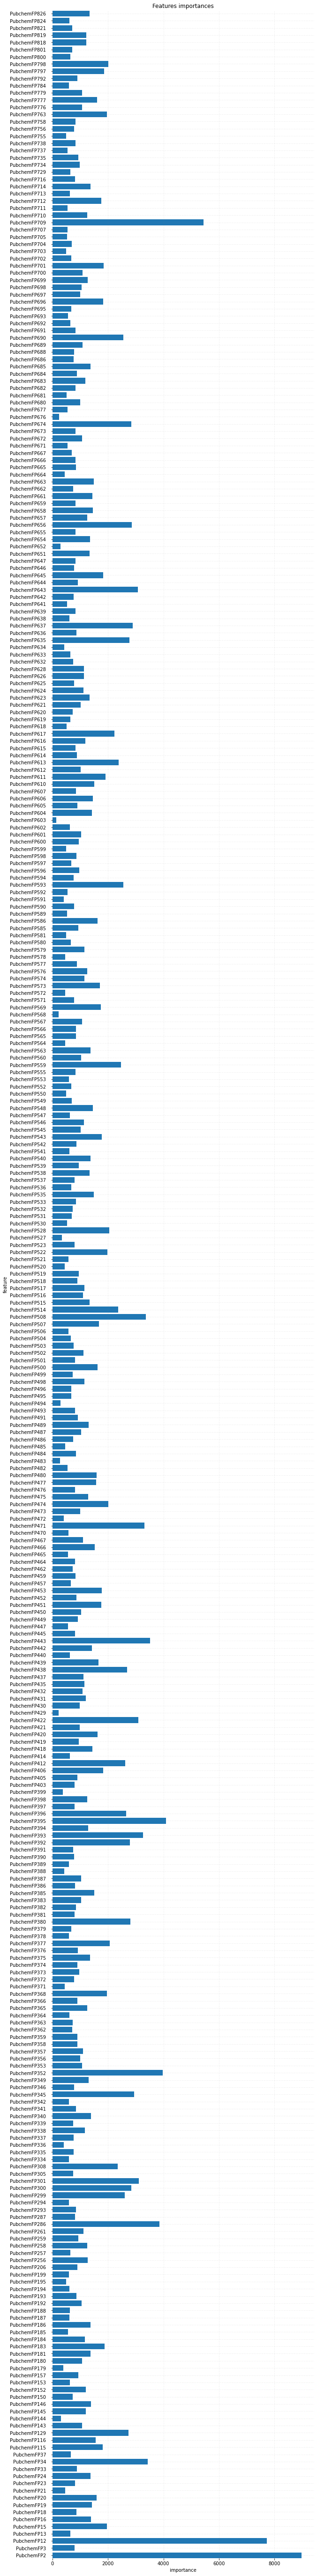

In [25]:
feature_importance = xgbr_best.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(keys, values)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [26]:
results_df = results_df.append(pd.DataFrame(data=[["XGBoost", *evaluate(y_test, xgbr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,13.999113,686.097141,26.193456,0.337430
1,Random Forest Regressor,11.583440,570.588496,23.886994,0.448978
2,XGBoost,10.880065,541.428723,23.268621,0.477138


## 5.4. LightGBM

Better results - third model.

In [202]:
# default: 'n_estimators': 100, 'num_leaves': 31, 'learning_rate': 0.1, 'max_depth': -1 
params = {
    'num_leaves': [50, 60, 70, 80],
    'learning_rate': [0.001, 0.005, 0.01],
    'max_depth': [5, 10, 15],
    'n_estimators': [1000, 2000, 3000],
    'min_child_samples': [30, 55, 65, 100],
    'reg_alpha': [1.7, 2.7, 3.7],
    'reg_lambda': [0.05, 0.1],
    'colsample_bytree': [0.25],
    'subsample': [0.8],
    'cat_smooth': [28],
}

grid = GridSearchCV(lgbm.LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

lgbm_reg = lgbm.LGBMRegressor(random_state=0)
lgbm_reg.fit(X_train,y_train)

lgbm_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, lgbm_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, lgbm_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, lgbm_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, lgbm_reg.predict(X_train))

Best params:  {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_samples': 65, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.1, 'subsample': 0.8} 

Test set:
Tuned model:
MAE: 10.65405489690598
MSE: 547.0995536840346
RMSE: 23.39015933430199
R2 Square 0.4716613740796157 

Base model:
MAE: 10.237120996793891
MSE: 504.1546173446204
RMSE: 22.453387658538755
R2 Square 0.5131336591564708 

Train set:
Tuned model:
MAE: 7.794699349118831
MSE: 254.64873852927593
RMSE: 15.95771720921498
R2 Square 0.7065491421973923 

Base model:
MAE: 7.220889004135903
MSE: 207.04754470871674
RMSE: 14.389146767919103
R2 Square 0.7614035712424644 



In [27]:
params = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 65, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.1, 
          'subsample': 0.8}

lgbm_best = lgbm.LGBMRegressor(**params) 
lgbm_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, lgbm_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, lgbm_best.predict(X_train))

Test set:
MAE: 10.646672624552238
MSE: 547.0986608573412
RMSE: 23.390140248774507
R2 Square 0.47166223628983905 

Train set:
MAE: 7.7940142859844075
MSE: 254.24832061903817
RMSE: 15.945166058057788
R2 Square 0.7070105738145973 



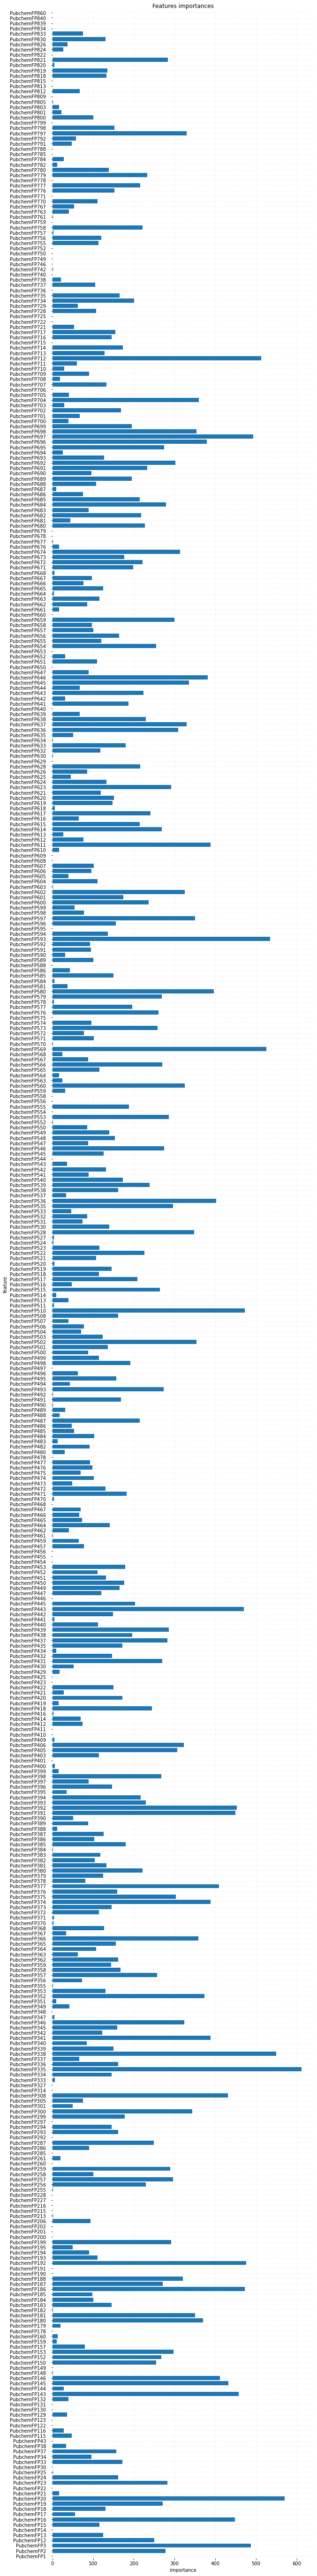

In [28]:
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), lgbm_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [29]:
results_df = results_df.append(pd.DataFrame(data=[["LightGBM", *evaluate(y_test, lgbm_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,13.999113,686.097141,26.193456,0.337430
1,Random Forest Regressor,11.583440,570.588496,23.886994,0.448978
2,XGBoost,10.880065,541.428723,23.268621,0.477138
3,LightGBM,10.646673,547.098661,23.390140,0.471662


## 5.5. Histogram-based Gradient Boosting Regressor (Regression Tree)

Better results - fourth model.

In [36]:
# default: 'learning_rate': 0.1, 'max_depth': None , 'l2_regularization': 0
params = {
    'learning_rate': [0.005, 0.1, 0.15],
    'max_depth': [5, 7, 10, 15, 20],
    'l2_regularization': [0, 0.01, 0.05],
    'min_samples_leaf':[10, 15, 20],
}

grid = GridSearchCV(HistGradientBoostingRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

hist_reg = HistGradientBoostingRegressor(random_state=0)
hist_reg.fit(X_train,y_train)

hist_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, hist_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, hist_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, hist_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, hist_reg.predict(X_train))

Best params:  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 10} 

Test set:
Tuned model:
MAE: 10.932035216103992
MSE: 552.092678702099
RMSE: 23.496652499922174
R2 Square 0.46683947138689963 

Base model:
MAE: 10.237120995380108
MSE: 504.1546170793415
RMSE: 22.453387652631427
R2 Square 0.5131336594126529 

Train set:
Tuned model:
MAE: 8.34332372663061
MSE: 260.1349594734558
RMSE: 16.128699869284436
R2 Square 0.7002269579546491 

Base model:
MAE: 7.220889003210652
MSE: 207.04754454184484
RMSE: 14.389146762120568
R2 Square 0.7614035714347633 



In [37]:
params = {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 10} 

hist_best = HistGradientBoostingRegressor(random_state=0, **params) 
hist_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, hist_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, hist_best.predict(X_train))

Test set:
MAE: 10.932035216103992
MSE: 552.092678702099
RMSE: 23.496652499922174
R2 Square 0.46683947138689963 

Train set:
MAE: 8.34332372663061
MSE: 260.1349594734558
RMSE: 16.128699869284436
R2 Square 0.7002269579546491 



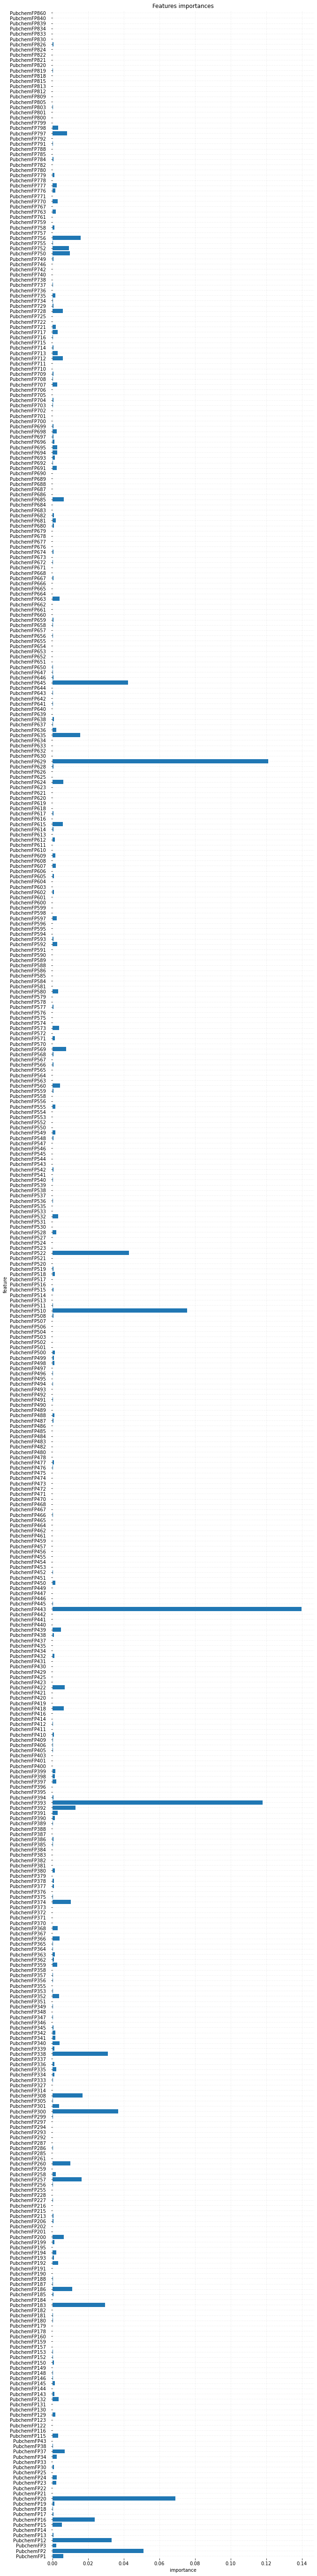

In [38]:
feature_importance = permutation_importance(hist_best, X_train, y_train, n_repeats=15, random_state=0)
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [39]:
results_df = results_df.append(pd.DataFrame(data=[["HistGradient Boosting Regressor", *evaluate(y_test, hist_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,13.999113,686.097141,26.193456,0.337430
1,Random Forest Regressor,11.583440,570.588496,23.886994,0.448978
2,XGBoost,10.880065,541.428723,23.268621,0.477138
3,LightGBM,10.646673,547.098661,23.390140,0.471662
4,HistGradient Boosting Regressor,10.932035,552.092679,23.496652,0.466839


## 5.6. Support Vector Regression

Better results - fifth model.

In [49]:
# default: 'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0, 'epsilon': 0.1
params = {
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [15.0, 30.0, 40.0],
    'epsilon': [2.8, 3.8, 6.8, 8.8],
}

grid = GridSearchCV(SVR(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

svr = SVR()
svr.fit(X_train,y_train)

svr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, svr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, svr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, svr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, svr.predict(X_train))

Best params:  {'C': 40.0, 'epsilon': 8.8, 'gamma': 'scale', 'kernel': 'rbf'} 

Test set:
Tuned model:
MAE: 11.503502870873497
MSE: 693.7893303005338
RMSE: 26.339880984934876
R2 Square 0.3300018269418953 

Base model:
MAE: 12.619864481780128
MSE: 1044.3904969619248
RMSE: 32.31703106663613
R2 Square -0.008576659172063517 

Train set:
Tuned model:
MAE: 9.75574092575427
MSE: 473.6039203944029
RMSE: 21.7624428866431
R2 Square 0.4542306492422009 

Base model:
MAE: 11.679399647647315
MSE: 864.7394968199907
RMSE: 29.40645331929695
R2 Square 0.0034957621105669023 



In [50]:
params = {'C': 40.0, 'epsilon': 8.8, 'gamma': 'scale', 'kernel': 'rbf'} 

svr_best = SVR(**params) 
svr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, svr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, svr_best.predict(X_train))

Test set:
MAE: 11.503502870873497
MSE: 693.7893303005338
RMSE: 26.339880984934876
R2 Square 0.3300018269418953 

Train set:
MAE: 9.75574092575427
MSE: 473.6039203944029
RMSE: 21.7624428866431
R2 Square 0.4542306492422009 



In [52]:
feature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)
fig, ax = plt.subplots(figsize=(10, 100))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

'\nfeature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)\nfig, ax = plt.subplots(figsize=(10, 100))\nax.barh(list(X_train.columns), feature_importance.importances_mean)\n\nfor s in [\'top\', \'bottom\', \'left\', \'right\']:\n    ax.spines[s].set_visible(False)\nax.yaxis.set_tick_params(pad=10)\nplt.margins(y=0)\nax.grid(b=True, color=\'grey\',linestyle=\'-.\', linewidth=0.5,alpha=0.2)\nax.set_xlabel("importance")\nax.set_ylabel("feature")\nax.set_title("Features importances")\nplt.show()\n'

In [53]:
results_df = results_df.append(pd.DataFrame(data=[["Support Vector Regression", *evaluate(y_test, svr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,13.999113,686.097141,26.193456,0.337430
1,Random Forest Regressor,11.583440,570.588496,23.886994,0.448978
2,XGBoost,10.880065,541.428723,23.268621,0.477138
3,LightGBM,10.646673,547.098661,23.390140,0.471662
4,HistGradient Boosting Regressor,10.932035,552.092679,23.496652,0.466839
5,Support Vector Regression,11.503503,693.789330,26.339881,0.330002


### Save models

In [118]:
'''
pickle.dump(rf_best, open('models/rf.pkl', 'wb'))
pickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))
pickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))
pickle.dump(hist_best, open('models/hist.pkl', 'wb'))
pickle.dump(svr_best, open('models/svr.pkl', 'wb'))
'''

"\npickle.dump(rf_best, open('models/rf.pkl', 'wb'))\npickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))\npickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))\npickle.dump(hist_best, open('models/hist.pkl', 'wb'))\npickle.dump(svr_best, open('models/svr.pkl', 'wb'))\n"

## 5.7. Stacking models

### Averaging base models

In [56]:
def average_predictions(X):
    return ((0.20 * rf_best.predict(X)) + \
            (0.25 * xgbr_best.predict(X)) + \
            (0.25 * lgbm_best.predict(X)) + \
            (0.25 * hist_best.predict(X)) + \
            (0.05 * svr_best.predict(X)))

print('Test set:')
print_evaluate(y_test, average_predictions(X_test))
print('Train set:')
print_evaluate(y_train, average_predictions(X_train))

Test set:
MAE: 10.574718512252296
MSE: 537.3705376605067
RMSE: 23.18125401397661
R2 Square 0.48105676642240813 

Train set:
MAE: 7.954169892610198
MSE: 244.13251903781534
RMSE: 15.62474060705698
R2 Square 0.7186677713664695 



In [57]:
results_df = results_df.append(pd.DataFrame(data=[["Averaging base models", *evaluate(y_test, average_predictions(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,13.999113,686.097141,26.193456,0.337430
1,Random Forest Regressor,11.583440,570.588496,23.886994,0.448978
2,XGBoost,10.880065,541.428723,23.268621,0.477138
3,LightGBM,10.646673,547.098661,23.390140,0.471662
4,HistGradient Boosting Regressor,10.932035,552.092679,23.496652,0.466839
5,Support Vector Regression,11.503503,693.789330,26.339881,0.330002
6,Averaging base models,10.574719,537.370538,23.181254,0.481057


### Averaging base models with Meta-model

In [58]:
meta_train = pd.DataFrame(data={
    "rf": rf_best.predict(X_train).tolist(),
    "xgbr": xgbr_best.predict(X_train).tolist(),
    "lgbm": lgbm_best.predict(X_train).tolist(),
    "hist_reg": hist_best.predict(X_train).tolist(),
    "svr_reg": svr_best.predict(X_train).tolist()
    })

    
meta_test = pd.DataFrame(data={
    "rf": rf_best.predict(X_test).tolist(),
    "xgbr": xgbr_best.predict(X_test).tolist(),
    "lgbm": lgbm_best.predict(X_test).tolist(),
    "hist_reg": hist_best.predict(X_test).tolist(),
    "svr_reg": svr_best.predict(X_test).tolist()
    })


In [59]:
meta_train

,rf,xgbr,lgbm,hist_reg,svr_reg
0,40.907677,22.644794,9.719590,50.897005,11.940406
1,7.813558,8.190458,9.430514,7.771244,11.425694
2,63.407580,68.275818,69.572816,76.994265,61.199872
3,6.325202,-6.466331,-2.263646,-0.766840,0.785418
4,6.170870,3.844742,2.587997,5.340183,8.433226
...,...,...,...,...,...
2806,17.265355,29.496593,27.521204,23.707336,21.799731
2807,8.272086,8.431551,9.218244,10.183914,8.738405
2808,6.149475,3.811652,3.690197,5.266913,9.599874
2809,14.025017,13.617995,15.431816,14.152165,17.070149


In [62]:
params = {'alpha': 0.1} 

meta_model = Ridge(**params)
meta_model.fit(meta_train, y_train)

print('Test set:')
print_evaluate(y_test, meta_model.predict(meta_test))

print('Train set:')
print_evaluate(y_train, meta_model.predict(meta_train))

Test set:
MAE: 10.535832590810044
MSE: 510.90203298113903
RMSE: 22.60314210416638
R2 Square 0.5066176233053965 

Train set:
MAE: 7.823161374976126
MSE: 204.03962939421424
RMSE: 14.284244096003619
R2 Square 0.7648698178625586 



In [63]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model", *evaluate(y_test, meta_model.predict(meta_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,13.999113,686.097141,26.193456,0.337430
1,Random Forest Regressor,11.583440,570.588496,23.886994,0.448978
2,XGBoost,10.880065,541.428723,23.268621,0.477138
3,LightGBM,10.646673,547.098661,23.390140,0.471662
4,HistGradient Boosting Regressor,10.932035,552.092679,23.496652,0.466839
5,Support Vector Regression,11.503503,693.789330,26.339881,0.330002
6,Averaging base models,10.574719,537.370538,23.181254,0.481057
7,Base models + Meta-model,10.535833,510.902033,22.603142,0.506618


### Averaging base models with Meta-model and k-fold cross validation

![Stacked](images/stacked.png)

In [64]:
params_rf = {'max_depth': 8, 'n_estimators': 2000} 

params_xgb = {'colsample_bytree': 0.4, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.4, 'max_depth': 15, 
          'min_child_weight': 120, 'n_estimators': 4000, 'subsample': 0.9} 

params_lgbm = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 65, 'n_estimators': 2000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.1, 
          'subsample': 0.8}

params_hist =  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 10}  

params_svr = {'C': 40.0, 'epsilon': 8.8, 'gamma': 'scale', 'kernel': 'rbf'} 

In [65]:
pred1 = np.zeros(X_train.shape[0])
pred2 = np.zeros(X_train.shape[0])
pred3 = np.zeros(X_train.shape[0])
pred4 = np.zeros(X_train.shape[0])
pred5 = np.zeros(X_train.shape[0])
models1 = []
models2 = []
models3 = []
models4 = []
models5 = []

kf = KFold(n_splits=6,random_state=48,shuffle=True)
n_fold = 0

for trn_idx, test_idx in kf.split(X_train, y_train):
    print(f"-------------- fold {n_fold+1} --------------")
    X_tr,X_val = X_train.iloc[trn_idx],X_train.iloc[test_idx]
    y_tr,y_val = y_train.iloc[trn_idx],y_train.iloc[test_idx]
     
    model1 = RandomForestRegressor(**params_rf)
    model1.fit(X_tr,y_tr)
    models1.append(model1)
    #pickle.dump(model1, open('models/stacked/m1{}.pkl'.format(n_fold+1), 'wb'))
    pred1[test_idx] = model1.predict(X_val)
    mse1 = mean_squared_error(y_val, pred1[test_idx])
    r21 = r2_score(y_val, pred1[test_idx])
    print("Model1 MSE: {}".format(mse1))
    print("Model1 R2: {}".format(r21))

    model2 = xgb.XGBRegressor(**params_xgb)
    model2.fit(X_tr,y_tr)
    models2.append(model2)
    #pickle.dump(model2, open('models/stacked/m2{}.pkl'.format(n_fold+1), 'wb'))
    pred2[test_idx] = model2.predict(X_val)
    mse2 = mean_squared_error(y_val, pred2[test_idx])
    r22 = r2_score(y_val, pred2[test_idx])
    print("Model2 MSE: {}".format(mse2))
    print("Model2 R2: {}".format(r22))
    
    model3 = lgbm.LGBMRegressor(**params_lgbm)
    model3.fit(X_tr,y_tr)
    models3.append(model3)
    #pickle.dump(model3, open('models/stacked/m3{}.pkl'.format(n_fold+1), 'wb'))
    pred3[test_idx] = model3.predict(X_val)
    mse3 = mean_squared_error(y_val, pred3[test_idx])
    r23 = r2_score(y_val, pred3[test_idx])
    print("Model3 MSE: {}".format(mse3))
    print("Model3 R2: {}".format(r23))
    
    model4 = HistGradientBoostingRegressor(**params_hist)
    model4.fit(X_tr,y_tr)
    models4.append(model4)
    #pickle.dump(model4, open('models/stacked/m4{}.pkl'.format(n_fold+1), 'wb'))
    pred4[test_idx] = model4.predict(X_val)
    mse4 = mean_squared_error(y_val, pred4[test_idx])
    r24 = r2_score(y_val, pred4[test_idx])
    print("Model4 MSE: {}".format(mse4))
    print("Model4 R2: {}".format(r24))
    
    model5 = SVR(**params_svr)
    model5.fit(X_tr,y_tr)
    models5.append(model5)
    #pickle.dump(model5, open('models/stacked/m5{}.pkl'.format(n_fold+1), 'wb'))
    pred5[test_idx] = model5.predict(X_val)
    mse5 = mean_squared_error(y_val, pred5[test_idx])
    r25 = r2_score(y_val, model5.predict(X_val))
    print("Model5 MSE: {}".format(mse5))
    print("Model5 R2: {}".format(r25))
           
    print("Average MSE = {}".format((mse1+mse2+mse3+mse4+mse5)/5))
    print("Average R2 = {}".format((r21+r22+r23+r24+r25)/5))

    n_fold+=1

-------------- fold 1 --------------
Model1 MSE: 645.5799572780151
Model1 R2: 0.41973408024002856
Model2 MSE: 637.9828912276448
Model2 R2: 0.4265625427248032
Model3 MSE: 644.7686413545208
Model3 R2: 0.4204633144351966
Model4 MSE: 626.8259203853195
Model4 R2: 0.4365907505007287
Model5 MSE: 881.9231034152386
Model5 R2: 0.20730203131069336
Average MSE = 687.4161027321477
Average R2 = 0.38213054384229006
-------------- fold 2 --------------
Model1 MSE: 598.7561277835814
Model1 R2: 0.28595316260121506
Model2 MSE: 444.4386415009721
Model2 R2: 0.4699845368492217
Model3 MSE: 422.5851113018941
Model3 R2: 0.49604597221592683
Model4 MSE: 449.3277657589902
Model4 R2: 0.46415400994169687
Model5 MSE: 541.4114909545546
Model5 R2: 0.35433953005455765
Average MSE = 491.3038274599985
Average R2 = 0.4140954423325236
-------------- fold 3 --------------
Model1 MSE: 341.27418445103217
Model1 R2: 0.44641038947744704
Model2 MSE: 280.49981646050105
Model2 R2: 0.5449940510566306
Model3 MSE: 278.0961089607258
M

In [66]:
test1 = np.zeros(X_test.shape[0])
test2 = np.zeros(X_test.shape[0])
test3 = np.zeros(X_test.shape[0])
test4 = np.zeros(X_test.shape[0])
test5 = np.zeros(X_test.shape[0])

n_splits = kf.n_splits

for model_id in range(n_splits):
    test1 += models1[model_id].predict(X_test)/n_splits
    test2 += models2[model_id].predict(X_test)/n_splits
    test3 += models3[model_id].predict(X_test)/n_splits
    test4 += models4[model_id].predict(X_test)/n_splits
    test5 += models5[model_id].predict(X_test)/n_splits

In [67]:
meta_train2 = pd.DataFrame(data={
    "rf": pred1.tolist(),
    "xgbr": pred2.tolist(),
    "lgbm": pred3.tolist(),
    "hist_reg": pred4.tolist(),
    "svr_reg": pred5.tolist(),
    })
meta_test2 = pd.DataFrame(data={
    "rf": test1.tolist(),
    "xgbr": test2.tolist(),
    "lgbm": test3.tolist(),
    "hist_reg": test4.tolist(),
    "svr_reg": test5.tolist()
    })

In [68]:
meta_train2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,81.013044,25.524366,19.768290,31.061554,14.735919
1,7.197123,11.797548,9.181466,8.861576,12.178103
2,45.414302,62.220562,62.907909,66.835586,51.480118
3,6.681384,-10.323265,-2.258571,-1.875448,1.071478
4,6.606363,4.013028,2.925756,5.512636,7.334141
...,...,...,...,...,...
2806,15.785541,27.985926,25.589552,21.341855,26.707630
2807,8.373881,3.206529,7.391926,3.394779,7.173022
2808,6.235678,4.974160,4.706194,5.760450,12.909987
2809,15.748935,18.541267,17.492616,14.948601,20.469695


In [69]:
meta_test2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,18.769244,27.472237,25.770904,22.129319,22.129943
1,7.877073,2.360554,3.051591,5.568546,5.951471
2,13.676323,16.601310,13.758138,18.898295,17.523343
3,58.177910,65.213571,63.191138,53.707956,34.285198
4,8.573107,12.700590,10.422678,10.995727,18.315520
...,...,...,...,...,...
699,13.312180,13.133504,21.935632,22.204308,14.850868
700,8.276717,7.923870,6.951691,5.777856,11.126932
701,13.280202,21.477957,26.605817,23.053873,17.357550
702,26.208819,40.917652,44.105865,39.823454,20.477913


In [70]:
params = {'alpha': 0.1} 

meta_model2 = Ridge(**params)
meta_model2.fit(meta_train2, y_train)

print('Test set:')
print_evaluate(y_test, meta_model2.predict(meta_test2))

print('Train set:')
print_evaluate(y_train, meta_model2.predict(meta_train2))

Test set:
MAE: 10.530093797908075
MSE: 551.2174097725024
RMSE: 23.4780197157363
R2 Square 0.4676847259305378 

Train set:
MAE: 10.127263793456706
MSE: 425.03310583009244
RMSE: 20.616331046771936
R2 Square 0.5102024450594014 



In [71]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model + cv", *evaluate(y_test, meta_model2.predict(meta_test2))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,13.999113,686.097141,26.193456,0.337430
1,Random Forest Regressor,11.583440,570.588496,23.886994,0.448978
2,XGBoost,10.880065,541.428723,23.268621,0.477138
3,LightGBM,10.646673,547.098661,23.390140,0.471662
4,HistGradient Boosting Regressor,10.932035,552.092679,23.496652,0.466839
5,Support Vector Regression,11.503503,693.789330,26.339881,0.330002
6,Averaging base models,10.574719,537.370538,23.181254,0.481057
7,Base models + Meta-model,10.535833,510.902033,22.603142,0.506618
8,Base models + Meta-model + cv,10.530094,551.217410,23.478020,0.467685
